In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

import warnings
warnings.filterwarnings('ignore')

In [2]:
probabilities = np.array([
[.925, .016, .014, .012, .01, .008, .006, .004, .002, .001, .0015, .0005, .0000],
[.9, .02, .016, .013, .012, .011, .009, .007, .005, .003, .002, .0015, .0005],
[.85, .02, .022, .02, .018, .016, .014, .012, .01, .008, .006, .003, .001],
[.8, .023, .026, .03, .024, .022, .019, .015, .013, .01, .008, .006, .004],
[.775, .023, .024, .027, .03, .025, .021, .019, .017, .014, .011, .008, .006],
[.75, .023, .025, .028, .03, .032, .026, .022, .019, .015, .012, .01, .008],
[.725, .022, .023, .025, .027, .029, .032, .029, .027, .023, .016, .012, .01],
[.7, .021, .022, .023, .027, .029, .031, .033, .031, .028, .025, .016, .014],
[.675, .02, .021, .024, .026, .028, .03, .032, .035, .032, .03, .025, .022],
[.65, .02, .021, .024, .026, .028, .031, .033, .035, .037, .035, .032, .028],
[.625, .022, .024, .026, .028, .03, .032, .033, .034, .036, .039, .037, .034],
[.6, .023, .026, .029, .031, .032, .033, .034, .035, .037, .039, .042, .039],
[.575, .024, .026, .028, .03, .032, .034, .037, .039, .041, .042, .045, .047],
])

def generate_data(n_samples = 10, n_tiers = 13, prob_dist = probabilities, max_value = 12):
    """
    Generate random data of size (n_tiers, n_samples). Follows
    probability distribution prob_dist when choosing each data sample.

    :param n_samples: Number of data points to sample per tier
    :param n_tiers: Number of tiers to use
    :param prob_dist: Probability distribution of size (n_tiers, range of possible values) that
        determines the probability of randomly selecting each possible value in each tier
    :param max_value: The maximum integer value of data to pull, assuming we pull data
        as integers from 0 to max_value.

    :return: (n_tiers, n_samples) fake dataset.
    """
    arr = np.zeros((n_tiers, n_samples), dtype = int)
    for row in range(n_tiers):
        probs = prob_dist[row]
        arr[row] = np.random.choice(range(max_value + 1), size=n_samples, p=probs)
    return arr

dataset = generate_data(n_samples = 50, n_tiers = 13)
p = np.linspace(0, 1, num = 50, endpoint = False).reshape(1, 50)
p = np.repeat(p, 13, axis = 0)
fake_preds = p + np.array(range(13)).reshape(-1, 1)

print(dataset.shape, fake_preds.shape)

dataset = dataset.ravel()
preds = fake_preds.ravel()

(13, 50) (13, 50)


In [3]:
print(f'Percent of data thats not zero: {len(dataset[dataset > 0]) / len(dataset):.2f}')

Percent of data thats not zero: 0.27


In [23]:
def custom_qcut(df, pred_colname, actual_colname, n_deciles):
    """"
    custom implementation of qcut to not throw boundary tie errors

    adds columns pred_colname_bin and actual_colname_bin to df with the prediction and actual bin numbers.

    ranks data, then performs qcut from the rank. data earlier in the df will get a lower rank.

    :param df: DataFrame to qcut on
    :param pred_colname: name of prediction column (str)
    :param actual_colname: name of actuals column (str)
    :param n_deciles: Number of bins

    :return: copy of df with pred_colname_bin and actual_colname_bin added
    """
    df.loc[:, 'pred_rank'] = df.loc[:, pred_colname].rank(method = 'first')
    df.loc[:, 'act_rank'] = df.loc[:, actual_colname].rank(method = 'first')
    df.loc[:, pred_colname + '_bin'] = pd.qcut(df.loc[: ,'pred_rank'], n_deciles, labels=False) + 1
    df.loc[:, actual_colname + '_bin'] = pd.qcut(df.loc[: ,'act_rank'], n_deciles, labels=False) + 1
    df = df.drop(['pred_rank', 'act_rank'], axis = 1)
    return df

In [41]:
def custom_cut(df, pred_colname, actual_colname, tiercuts):
    """
    Performs pd.cut on df[pred_colname] using tiercuts, then finds the number of rows in each tier,
    and cuts the actuals into tiers by sorting them, then making tiers that contain the same number
    of rows as the prediction tiers.

    :param df: dataframe to cut with predictions and actuals
    :param pred_colname: name of prediction column (str)
    :param actual_colname: name of actuals column (str)
    :param tiercuts: tier edges to use to cut predictions (list of scalars or list of tuples)
    :return: df with columns 'pred_bin' and 'actual_bin' designating each row's tier number
        based on predictions and actuals
    """
    if isinstance(tiercuts, list) and all(isinstance(i, tuple) for i in tiercuts):
        tiercuts = pd.IntervalIndex.from_tuples(tiercuts)

    # TODO: validate that the labels work regardless of the type of tiercuts
    df['pred_bin'] = pd.cut(df[pred_colname], tiercuts, labels = range(1, len(tiercuts)))
    tier_counts = df['pred_bin'].value_counts().sort_index().reset_index()

    # Sort the actual values
    sorted_actuals = df.sort_values(by=actual_colname).reset_index(drop=True)

    # Generate actual bins by cumulative record counts
    actual_bins = []
    for i, count in enumerate(tier_counts['count']):
        actual_bins += [tier_counts['pred_bin'][i]] * count

    # Assign actual bins back to the DataFrame
    sorted_actuals['actual_bin'] = actual_bins

    return sorted_actuals

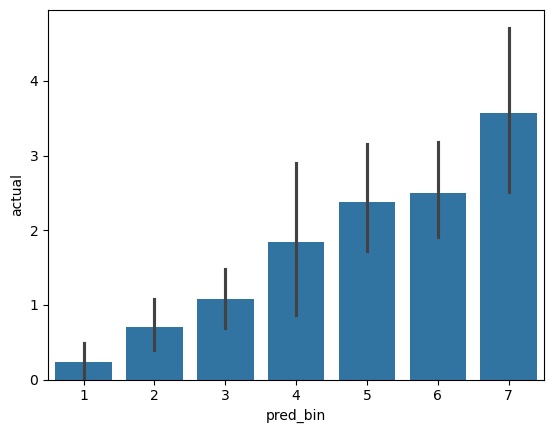

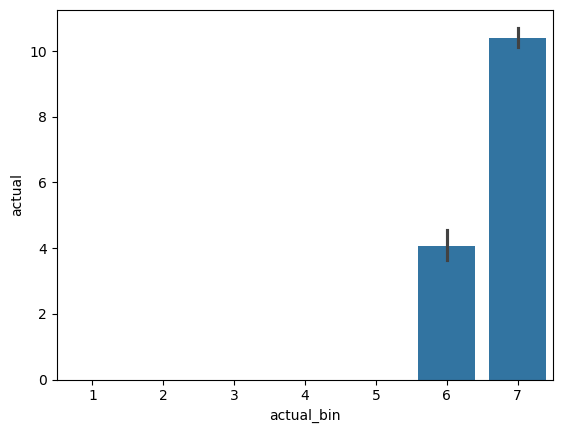

In [43]:
tiercuts = [-0.1, 1, 3, 6, 7, 9, 12, 14]

df = pd.DataFrame({'pred': preds, 'actual': dataset})
result = custom_cut(df, 'pred', 'actual', tiercuts)

sns.barplot(x = result['pred_bin'], y = result['actual'])
plt.show()
sns.barplot(x = result['actual_bin'], y = result['actual'])
plt.show()

In [78]:
def generate_lcro_report(df, pred_agg, act_agg, slope, monotonicity, monotonicity_param, combined_metric, slope_std, n_bins, plot_actuals):
    plot_max = act_agg['actual'].iloc[-1]*1.05
    plot_min = act_agg['actual'].iloc[0]*0.9


    # barplot of prediction lift chart

    if plot_actuals:
        plt.figure(figsize = (10, 4))
        plt.subplot(1, 2, 1)
    sns.barplot(x = pred_agg['pred_bin'], y = pred_agg['actual'], errorbar = None)
    if plot_actuals:
        plt.ylim((plot_min, plot_max))
    plt.xlabel('Prediction Tier')
    plt.ylabel('Average Actual')
    plt.title('Lift Chart of Predictions, {} Tiers'.format(n_bins))

    # barplot of actuals
    if plot_actuals:
        plt.subplot(1, 2, 2)
        sns.barplot(x = act_agg['actual_bin'], y = act_agg['actual'], errorbar = None)
        plt.ylim((plot_min, plot_max))
        plt.xlabel('Actual Tier')
        plt.ylabel('Average Actual')
        plt.title('Lift Chart of Actuals, {} Tiers (Perfect Model)'.format(n_bins))

        plt.tight_layout()
    plt.show()

    # calculate other metrics
    # average standard deviation within tiers

    if plot_actuals:
        plt.figure(figsize = (10, 4))
        plt.subplot(1, 2, 1)
    std_agg = df.groupby('pred_bin', observed = False)['actual'].std().reset_index()
    plot_max = max(std_agg['actual'])*1.05
    sns.barplot(x = std_agg['pred_bin'], y = std_agg['actual'], ci = None)
    plt.title('Standard Deviation of Actuals Within Prediction Tier')
    plt.xlabel('Prediction Tier')
    plt.ylabel('Standard Deviation of Actuals')
    plt.ylim((0, plot_max))

    if plot_actuals:
        plt.subplot(1, 2, 2)
        std_agg = df.groupby('actual_bin', observed = False)['actual'].std().reset_index()
        sns.barplot(x = std_agg['actual_bin'], y = std_agg['actual'], ci = None)
        plt.title('Standard Deviation of Actuals Within Actual Tier')
        plt.xlabel('Actual Tier')
        plt.ylabel('Standard Deviation of Actuals')
        plt.ylim((0, plot_max))

        plt.tight_layout()
    plt.show()

    # display metrics
    print('\n')
    print('-----------------------------------------------------------------------------')
    print('LIFT CHART RANK ORDER REPORT')
    print('Monotonicity: {:.4f} -- Penalized Monotonicity with Param {}: {:.4f}'.format(monotonicity, monotonicity_param, (monotonicity - monotonicity_param) / (1 - monotonicity_param)))
    print('Slope Score: {:.4f}'.format(slope))
    print('Combined Metric: {:.4f}'.format(combined_metric))
    print('\n')
    print('Standard deviation of tier-to-tier deltas: {:.4f}'.format(slope_std))
    print('-----------------------------------------------------------------------------')

In [79]:
def rank_order(actuals, predictions, n_bins = 13, tiercuts = None, monotonicity_param = 0.9, generate_report = False, plot_actuals = False):
    """
    Given two arrays of predictions and actuals, calculate custom rank order score("LCRO").
    This is performed in the following way:

    1. Cut predictions into n_bins tiers, and find the average actual of each tier.
    2. Calculate a monotonicity score: the extent to which each tier's average is greater
        than the previous tier's (measured as spearman correlation between tier number
        and tier average).
    2.5. Penalize monotonicity according to monotonicity_param (default 0.9) -
        assuming that our models will generally have monotonicity > 0.9, convert monotonicity
        m to (m - 0.9) / 0.1. This converts a score of 0.95 to 0.5, 0.99 to 0.9, 0.91 to 0.1, etc.
        If monotonicity < 0.9, we will get a negative LCRO.
    3. Calculate a slope score to indicate what percentage of possible tier separation is achieved:
        i. Take the difference of the average actual for the highest prediction tier and the lowest
            prediction tier
        ii. Cut the actuals into the same number of tiers, and take the difference of the average actual
            for the highest actual tier and the average actual for the lowest actual tier. This represents
            what the slope would be of a model that rank ordered perfectly.
        iii. Divide item i) by item ii) to get a final slope score: percentage of possible tier
            separation achieved.
    4. Return monotonicity * slope as the rank order score - the score is primarily based on
        slope, but decreases for imperfect monotonicity.

    :param actuals: Array of actuals.
    :param predictions: Array of predictions.
    :param generate_report: Bool, whether to print a detailed report
    :param n_bins: How many tiers to cut predictions into for calculation. Default = 30
    :param monotonicity_param: What Spearman correlation should set the penalized monotonicity score to 0, or the
        minimum monotonicity we might expect. Default = 0.9
    :param tiercuts: List of scalars or list of tuples, explicit tiers to cut predictions into. Default: None
    :param plot_actuals: Bool, whether to plot the charts for actuals in report.

    :return: Combined LCRO score
    """
    df = pd.DataFrame({'pred': predictions, 'actual': actuals})
    if tiercuts is not None:
        df = custom_cut(df, 'pred', 'actual', tiercuts)
    else:
        df = custom_qcut(df, 'pred', 'actual', 13)
    pred_agg = df.groupby('pred_bin', observed = False)['actual'].mean().reset_index()
    act_agg = df.groupby('actual_bin', observed = False)['actual'].mean().reset_index()


    deltas = [pred_agg['actual'].iloc[i + 1] - pred_agg['actual'].iloc[i] for i in range(n_bins - 1)]
    slope_std = np.std(deltas)

    # spearman correlation of pred tier number and average actual
    monotonicity = spearmanr(pred_agg['pred_bin'], pred_agg['actual'])[0]

    # calculate slope score
    pred_slope = pred_agg['actual'].iloc[-1] - pred_agg['actual'].iloc[0]
    perfect_slope = act_agg['actual'].iloc[-1] - act_agg['actual'].iloc[0]
    slope = pred_slope / perfect_slope

    # apply scaling to monotonicity and return the score
    combined_metric = (monotonicity - monotonicity_param) / (1 - monotonicity_param) * slope

    if generate_report:
        generate_lcro_report(df, pred_agg, act_agg, slope, monotonicity, monotonicity_param, combined_metric, slope_std, n_bins, plot_actuals)


    return combined_metric

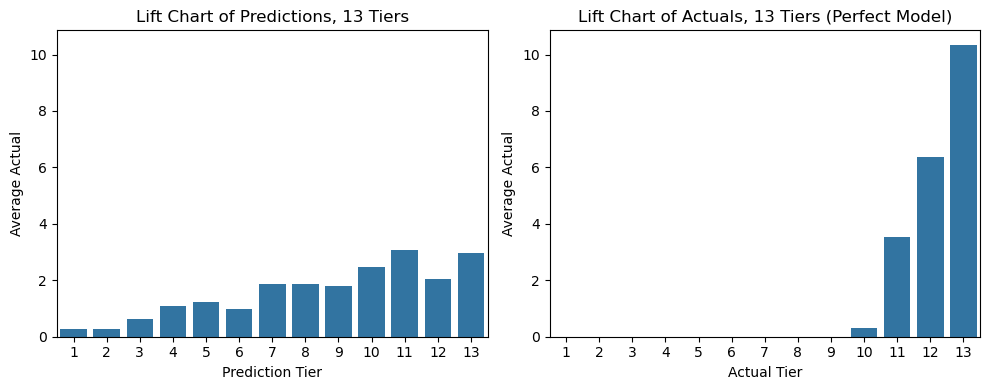

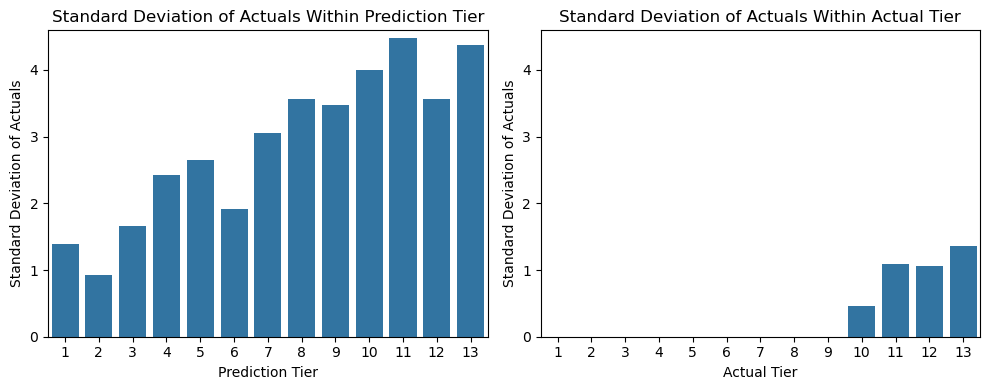



-----------------------------------------------------------------------------
LIFT CHART RANK ORDER REPORT
Monotonicity: 0.9326 -- Penalized Monotonicity with Param 0.9: 0.3260
Slope Score: 0.2592
Combined Metric: 0.0845


Standard deviation of tier-to-tier deltas: 0.5357
-----------------------------------------------------------------------------


0.08449673808800956

In [73]:
rank_order(dataset, preds, True, 13, 0.9, True)

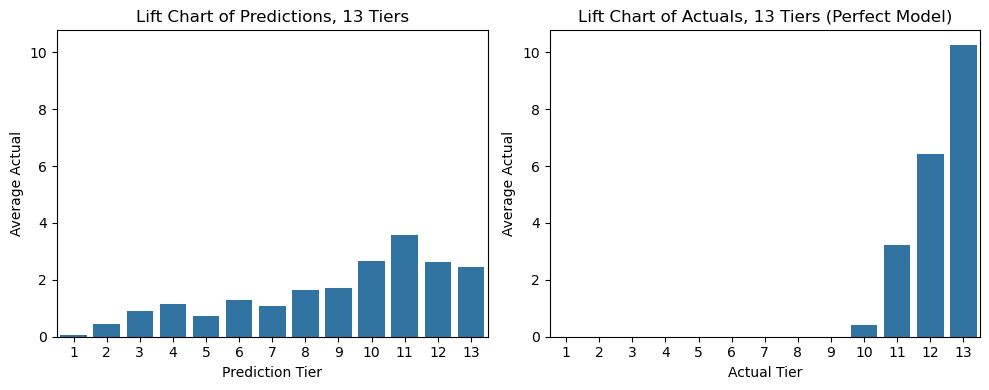

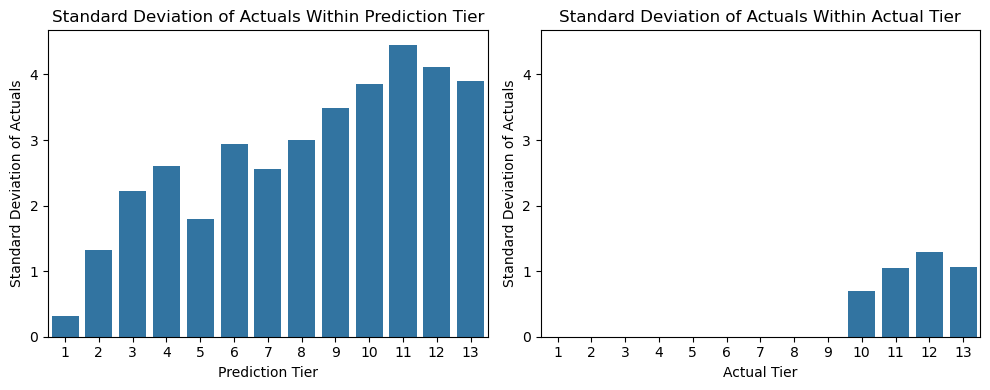



-----------------------------------------------------------------------------
LIFT CHART RANK ORDER REPORT
Monotonicity: 0.9121 -- Penalized Monotonicity with Param 0.9: 0.1209
Slope Score: 0.2339
Combined Metric: 0.0283


Standard deviation of tier-to-tier deltas: 0.5370
-----------------------------------------------------------------------------


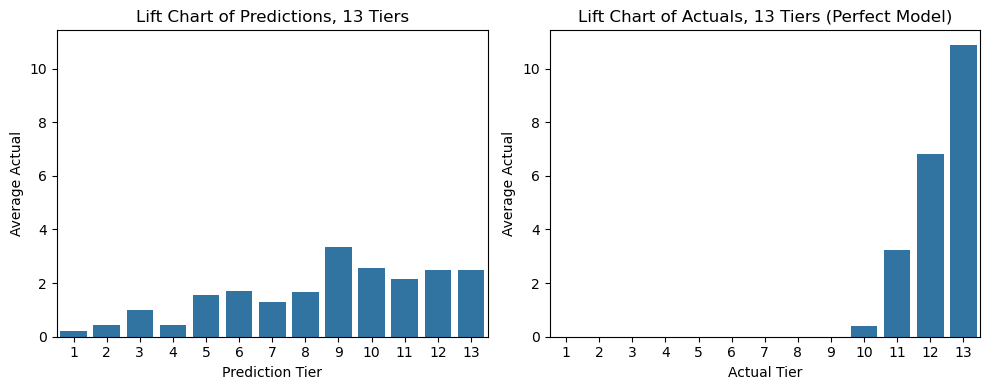

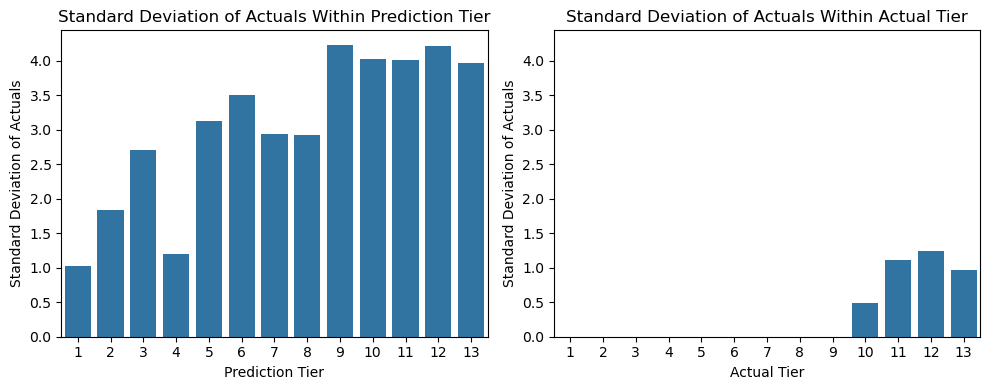



-----------------------------------------------------------------------------
LIFT CHART RANK ORDER REPORT
Monotonicity: 0.8666 -- Penalized Monotonicity with Param 0.9: -0.3342
Slope Score: 0.2096
Combined Metric: -0.0700


Standard deviation of tier-to-tier deltas: 0.6852
-----------------------------------------------------------------------------


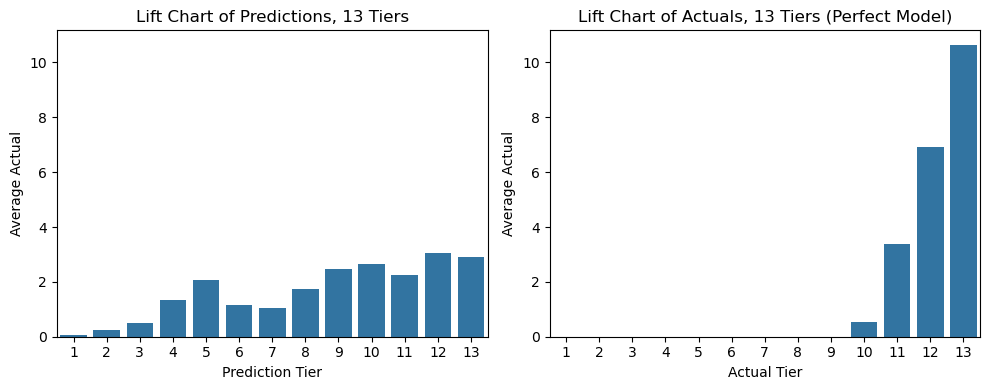

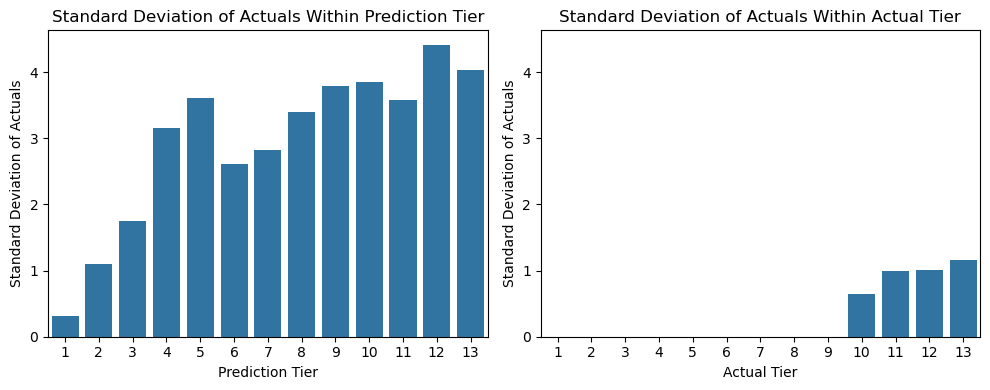



-----------------------------------------------------------------------------
LIFT CHART RANK ORDER REPORT
Monotonicity: 0.9121 -- Penalized Monotonicity with Param 0.9: 0.1209
Slope Score: 0.2669
Combined Metric: 0.0323


Standard deviation of tier-to-tier deltas: 0.5234
-----------------------------------------------------------------------------


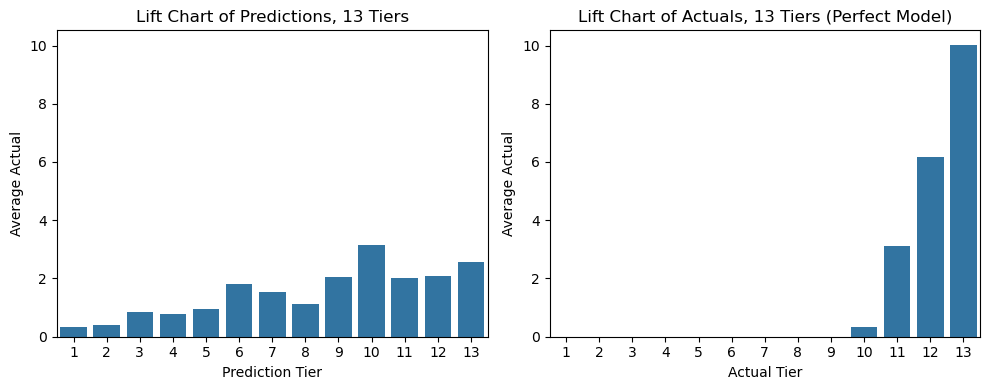

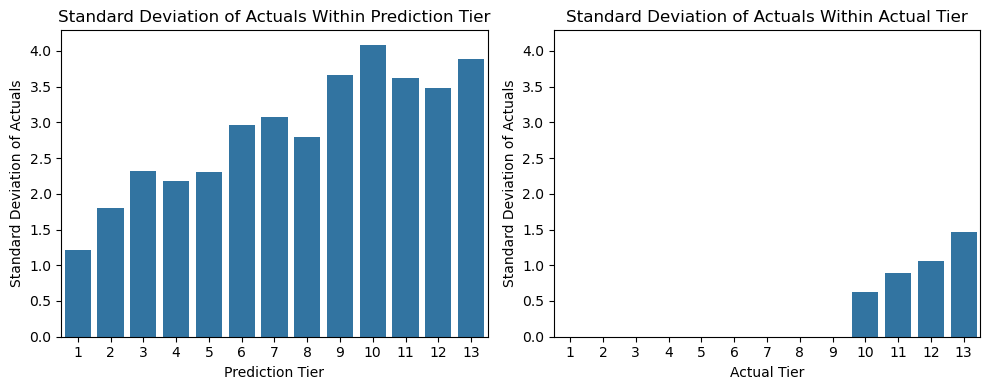



-----------------------------------------------------------------------------
LIFT CHART RANK ORDER REPORT
Monotonicity: 0.9286 -- Penalized Monotonicity with Param 0.9: 0.2857
Slope Score: 0.2236
Combined Metric: 0.0639


Standard deviation of tier-to-tier deltas: 0.6098
-----------------------------------------------------------------------------


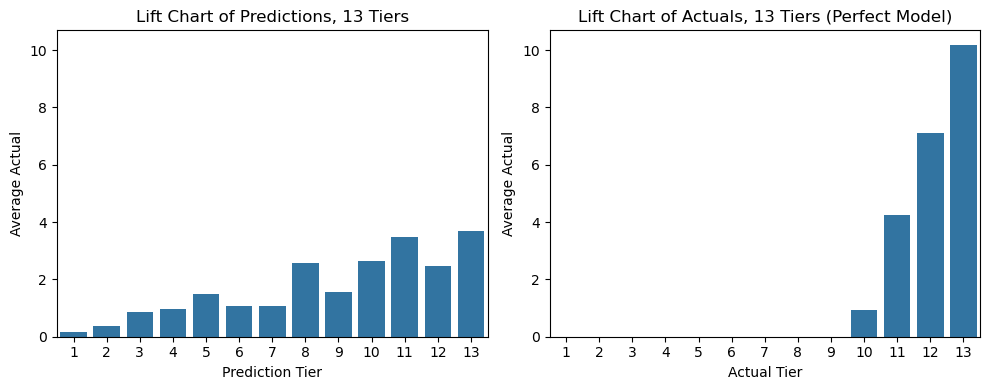

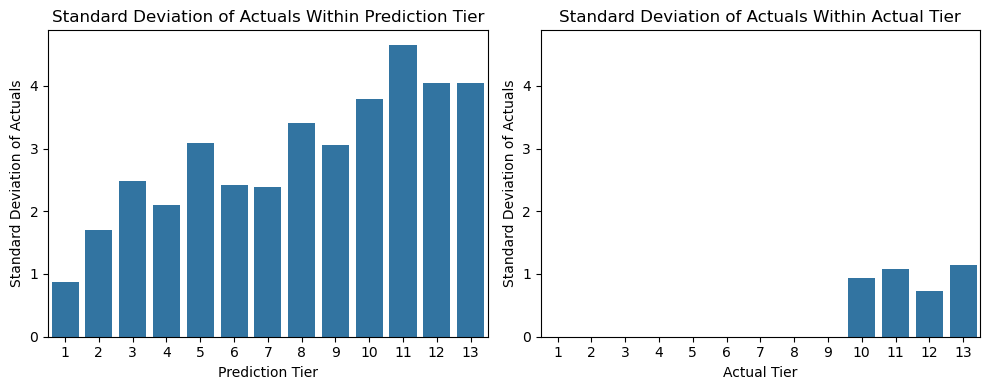



-----------------------------------------------------------------------------
LIFT CHART RANK ORDER REPORT
Monotonicity: 0.9381 -- Penalized Monotonicity with Param 0.9: 0.3810
Slope Score: 0.3458
Combined Metric: 0.1317


Standard deviation of tier-to-tier deltas: 0.7807
-----------------------------------------------------------------------------


In [80]:
for i in range(5):
    dataset = generate_data(n_samples = 50, n_tiers = 13)
    p = np.linspace(0, 1, num = 50, endpoint = False).reshape(1, 50)
    p = np.repeat(p, 13, axis = 0)
    fake_preds = p + np.array(range(13)).reshape(-1, 1)

    dataset = dataset.ravel()
    preds = fake_preds.ravel()
    rank_order(dataset, preds, True, 13, 0.9, True)
    